# "[DL] Experiments with activation functions and weights initialization"
> "Investigate the distributions of activations throught layers with different activation functions and weights initialization"

- toc:false
- branch: master
- badges: false
- comments: true
- author: Peiyi Hung
- categories: [category, learning]
- image:"images/tanh.png"

# Introduction

Training a deep neural network is hard. One of the reasons that makes it so challenging is vanishing/exploding gradient problem. This problem can be partly resolved by carefully initializing your weights. But, the questions bothering me are: **How does these weight initialization techniques affect the learning process?** and **What would happen if we use inappropriate weights initalization?** Therefore, in this article, I run an experiment with different weight initialization approaches for different activation functions and observe how the activations change while passing through a deep neural network.

The experiment is simple. I will make a fully-connnected network with six hidden layers, pass random values into the network, and plot and observe the distributions of activations. In the experiment, two commonly used activation functions are under consideration: tanh and ReLU. For each function, I initialize the weights which are normally distributed with zero mean and different variances. Weights initialized with small variances would cause the acticvations vanishing, while weights with large may cause activations exploding or activation function satuartes. So, to successfully train our neural network, we should use appropriate weight initialization. The proper initialization methods are Xavier initialization for tanh ([Golorot and Bengio, 2010](http://proceedings.mlr.press/v9/glorot10a.html)) and He initialzation for ReLU ([He et al., 2015](https://arxiv.org/abs/1502.01852?wm=1027?1)). By observing the distributions of activations, we can see how these two initialization method help us to trian neural networks. Also, I will briefly show why these two methods works before experimenting with these two methods.

Here's the code for the experiment:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def experiment(weights_multipler, act_func, lim, ticks):
    """
    Make a neural network with activation function 'act_func' and 
    weight initialization 'weights_multipler', and plot the distributions
    of activations in each layer.
    """
    
    # model
    n_layers = 7
    hidden_size = 4096
    batch_size = 16
    dims = [hidden_size] * n_layers

    x = np.random.randn(batch_size, dims[0])

    activations = []
    for Din, Dout in zip(dims[:-1], dims[1:]):
        W = weights_multipler * np.random.randn(Din, Dout)
        x = act_func(x.dot(W))
        activations.append(x)
    
    
    # plot
    fig, axes = plt.subplots(ncols=n_layers-1, figsize=(25, 4))

    for i, ax in enumerate(axes):
        acts = activations[i].reshape(-1)
        ax.hist(acts, bins=80)
        ax.set_xlim(*lim)
        ax.set_xticks(ticks)
        title = f"""
        Layer {i+1}
        mean={acts.mean():.2f},
        std={acts.std():.2f}
                    """

        ax.set_title(title)

    plt.tight_layout()

This article is inpsired by the lecture 10 of the course, [Deep Learning for Computer Vision](https://www.youtube.com/playlist?list=PL5-TkQAfAZFbzxjBHtzdVCWE0Zbhomg7r), taught by [Justin Johnson](https://web.eecs.umich.edu/~justincj/). 

# Tanh

Let's take a look at tanh. 

Formula:
$$\text{tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

Derivative of Tanh(x):
$$\text{tanh}'(x) = 1 - \text{tanh}^2(x)$$

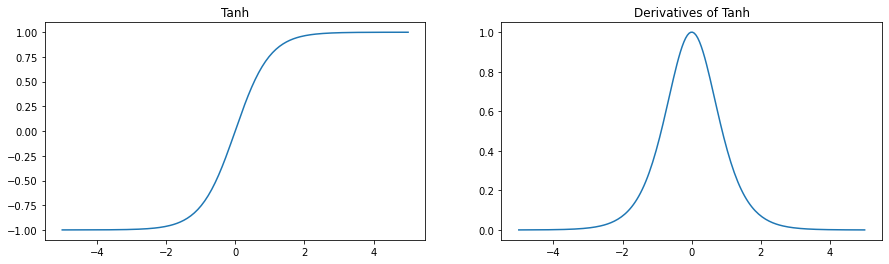

In [3]:
#collapse-hide
x = np.linspace(-5, 5, 200)
y = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
derivative = 1 - y**2

fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

axes[0].plot(x, y)
axes[0].set_title("Tanh")
axes[1].plot(x, derivative)
axes[1].set_title("Derivatives of Tanh");

Tanh function is a S-shaped function bounded within -1 and 1. Most derivative values are around 0 and become close to zero when it gets larger or smaller. 

We first try a small variance.

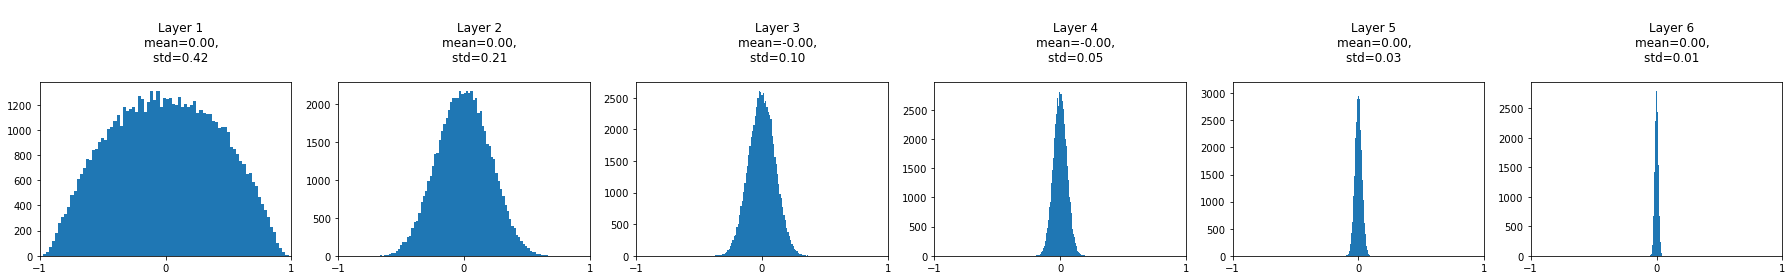

In [6]:
experiment(0.008, np.tanh, (-1,1), (-1, 0, 1))

We can see that the distributions of activations shrink as the data pass through the network and most of activations concentrate around zero in the last hidden layer. What would happen if most of our actications are zero? Assuming that we want to compute the gradient of weights in layer $l$, we can decompose the derivative into two parts:
$$ \frac{\partial{L}}{\partial{w_l}} = \frac{\partial{L}}{\partial{z_l}}\frac{\partial{z_l}}{\partial{w_l}}$$
where $L$ is the loss function, $z_l$ is the activation of layer $l$, and $w_l$ is the weight of layer $l$. By applying simple derivative rules, we get $\frac{\partial{z_l}}{\partial{w_l}} = z_{l-1}$. If $z_{l-1}$ is zero, then $\frac{\partial{L}}{\partial{w_l}}$ will also be zero. Zero gradient means the weights do not update and our network are not getting better.

Next, we try a big variance.

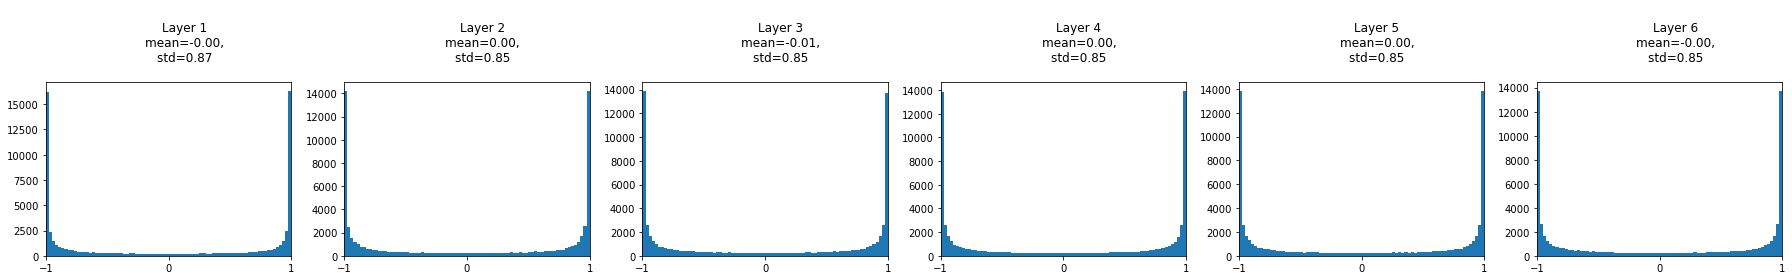

In [9]:
experiment(0.05, np.tanh, (-1,1), (-1, 0, 1))

Most of activations are around -1 or 1. Within these areas, the slope of tanh are flat and the gradients are close to zero. This is usually referred to as "saturation". Since most gradients are zero, our network is not learning.

The right initialization method for tanh is **Xavier initialization**.

**Core idea**: variance of input = variance of output

We have

$$y=Wx,\quad y_i = \displaystyle\sum_{j=1}^{Din}x_jw_{ij}$$

where $y_i$ is the ith element of $y$, $x_j$ is the jth element of $x$, and $w_{ij}$ is the element in ith row, jth col of $W$.

Assuming that $x$ and $W$ are iid and zero-mean, then we got:
$$
    \text{Var}(y_i)  =  D_{in} \times \text{Var}(x_jw_{ij}) =  D_{in} \times \text{Var}(x_j) \times \text{Var}(w_{ij})
$$

If $\text{Var}(w_{ij}) = \frac{1}{D_{in}}$, then $\text{Var}(y_i) = \text{Var}(x_j)$. We set $\text{std}(w) = \frac{1}{\sqrt{D_{in}}}$

How do we get $ \text{Var}(x_jw_{ij}) = \text{Var}(x_j)\text{Var}(w_{ij})$? We know that $\text{Var}(x_jw_{ij}) = \text{E}(x_j^{2}w_{ij}^2) - \text{E}(x_j)\text{E}(w_{ij})$. Since $x$ and $w$ are both zero-mean and independent, we have $\text{Var}(x_jw_{ij}) = \text{E}(x_j^{2})\text{E}(w_{ij}^2) = \text{Var}(x_j)\text{Var}(w_{ij})$.

Let's try this method:

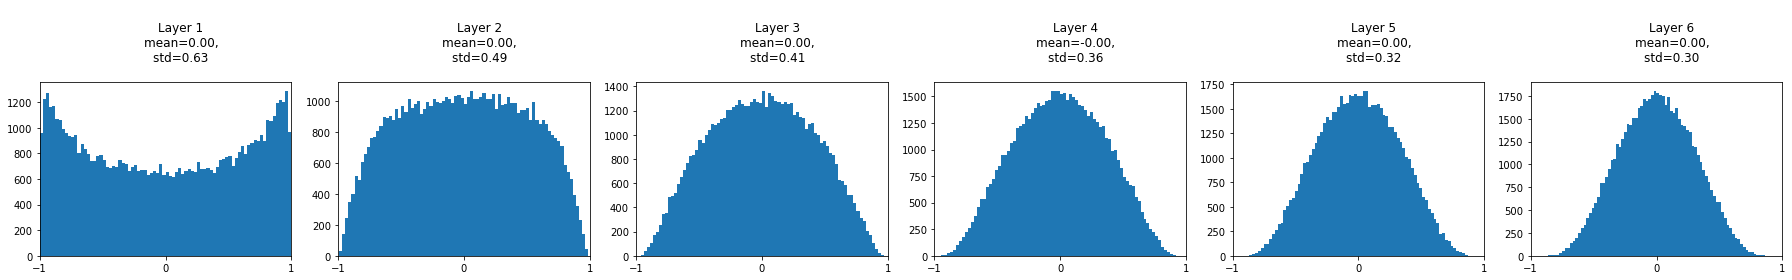

In [12]:
experiment(1/np.sqrt(4096), np.tanh, (-1,1), (-1, 0, 1))

By using Xavier initialization, we can get stable activation distributions in contrast to previous two cases.

# ReLU

The next activation function we are going to discuss is rectified linear units (ReLU). Here's the formula of ReLU and its derivatives, implementation of ReLU in numpy, and plots of ReLU formula and derivatives.

Formula: 
$$f(x) = \text{max}(0, x)$$

Derivatives:
$$f'(x) = 
\begin{cases}
    x, \; \text{if } x > 0\\ 
    0, \; \text{if } x \leq 0
\end{cases}
$$

In [14]:
def relu(x):
    return np.clip(x, 0, None)

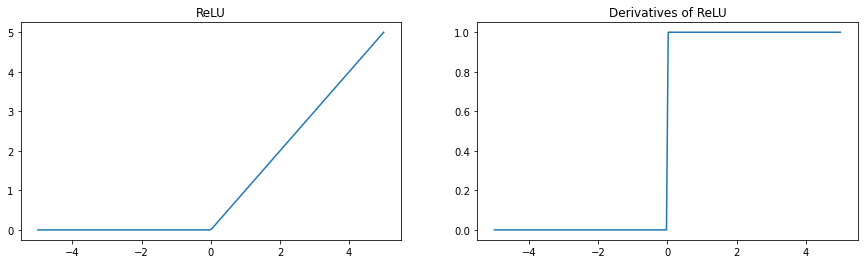

In [28]:
#collapse-hide
x = np.linspace(-5, 5, 200)
y = relu(x)
derivative = y > 0

fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

axes[0].plot(x, y)
axes[0].set_title("ReLU")
axes[1].plot(x, derivative)
axes[1].set_title("Derivatives of ReLU");

As in the tanh section, we first try a normal distribution with a small variance to initialize weights.

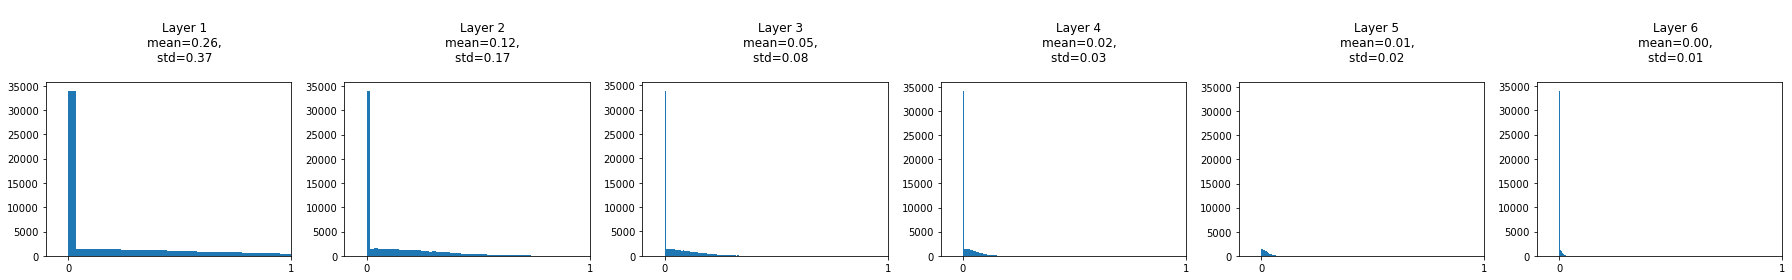

In [15]:
experiment(0.01, relu, (-0.1, 1), (0, 1))

Almost all activations are zero. This is problematic as explained in previous section. We next try a distribution with large variance.

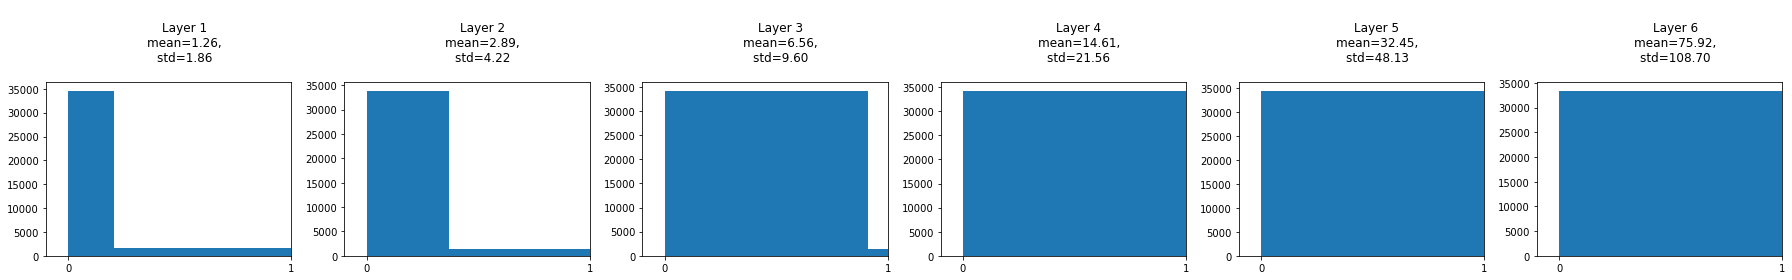

In [16]:
experiment(0.05, relu, (-0.1, 1), (0, 1))

The activations become larger as the data pass throught the network. Because of the charateristic of ReLU, the gradients will also get larger. An extremely large gradient causes numerical overflow which is not good for optimization.

We should use **Kaiming initialization / He initialization** for ReLU.

Kaiming initialization follows the same core idea as Xavier initialization but considers the case of ReLU being the activation function.

For a single convolutional layer $l$, we have
$$
x_l = f(y_{l-1}) \\
y_l = W_lx_l+b_l
$$
where $x_l$ is the input of this layer, $y_l$ is the output before activation, $f$ is ReLU function, and $W_l$ and $b_l$ are weights and bias of this layer.

Following a similar setting with Xavier initialization, we have 
$$ \text{Var}(y_l)  =  D_{l} \times \text{Var}(x_lw_{l}) $$

But now we cannot decompose $\text{Var}(x_lw_{l})$ into $\text{Var}(x_l)\text{Var}(w_{l})$ because ReLU is not centered at zero as tanh. Instead, we can only have $\text{Var}(y_l)  =  D_{l} \times \text{Var}(w_{l})\text{E}(x_l^2)$.

If we let $w_{l}$ have a zero-mean and symmetric distribution and set $b_l$ to zero, distribution of $y_l$ will also be zero-mean and symmetric. When we pass $y_l$ into ReLU, the negative half of distribution will be eliminate. This lead to $\text{E}(x_l^2) = \frac{1}{2}\text{Var}(y_{l-1})$. Then we have $\text{Var}(y_l)  =  D_{l} \times \text{Var}(w_{l})\times \frac{1}{2}\text{Var}(y_{l-1})$.

Consider the $L$th layer, variance of $y_L$ would be
$$
\text{Var}(y_L)  = \text{Var}(y_{1}) \big(\prod_{l=2}^{L} \frac{1}{2}D_l\text{Var}(w_{l})\big)
$$
We want to avoid the variance to grow or reduce exponetially, so we can have
$$
 \frac{1}{2}D_l\text{Var}(w_{l})=1, \forall l \; \rightarrow \text{std}(w_l) = \sqrt{2/D_{l}}
$$

Here's how it works in our experiment:

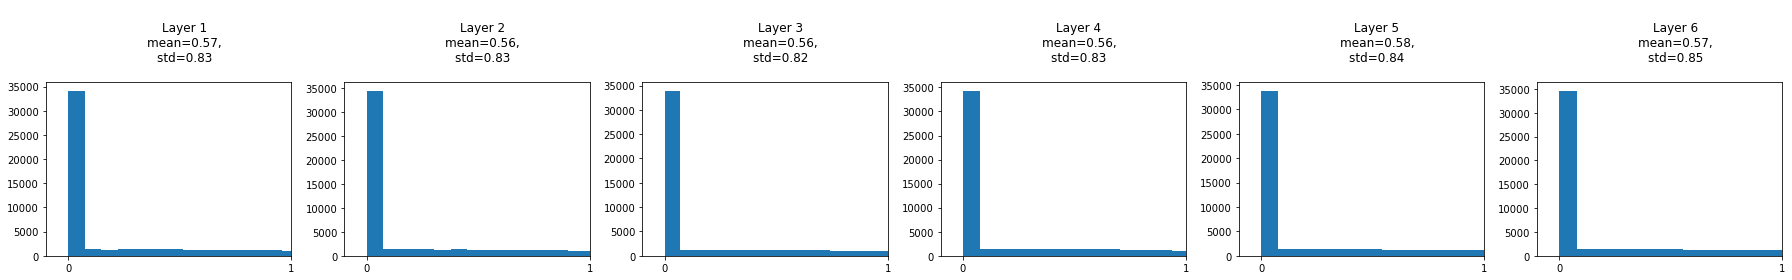

In [17]:
experiment(np.sqrt(2/4096), relu, (-0.1, 1), (0, 1))

As shown in plot above, Kaiming initializtion successfully avoids extreme cases in previous two plots and get stable distributions.

# Summary

If we don't carefully specify initialization methods, we may get gradients that are extremely big or small, in both of which case our network fails to learn properly. We should use Xavier initialization for tanh function and Kaiming initialization for ReLU function. Both these two methods share the same core idea: Input variance should be equal to output variance. This idea helps us to avoid cases of getting extremely big or extremely small activations and gradients.